#Python Chess AIES


**libraries**

---

In [ ]:
!pip3 install python-chess
!pip3 install cairosvg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
import chess
import chess.svg
import cairosvg
from cairosvg import svg2png
from collections import OrderedDict
from operator import itemgetter
import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
path_to_model = '/content/chess-aies-model/aies_model'

global model
model = tf.saved_model.load(path_to_model)


def predict(df_eval, imported_model):

    col_names = df_eval.columns
    dtypes = df_eval.dtypes
    predictions = []
    for row in df_eval.iterrows():
      example = tf.train.Example()
      for i in range(len(col_names)):
        dtype = dtypes[i]
        col_name = col_names[i]
        value = row[1][col_name]
        if dtype == 'object':
          value = bytes(value, 'utf-8')
          example.features.feature[col_name].bytes_list.value.extend([value])
        elif dtype == 'float':
          example.features.feature[col_name].float_list.value.extend([value])
        elif dtype == 'int':
          example.features.feature[col_name].int64_list.value.extend([value])
      predictions.append(imported_model.signatures['predict'](examples = tf.constant([example.SerializeToString()])))
    return predictions


def get_board_features(board):

    board_features = []
    for square in chess.SQUARES:
      board_features.append(str(board.piece_at(square)))
    return board_features


def get_move_features(move):

    from_ = np.zeros(64)
    to_ = np.zeros(64)
    from_[move.from_square] = 1
    to_[move.to_square] = 1
    return from_, to_


def get_possible_moves_data(current_board):

    data = []
    moves = list(current_board.legal_moves)
    for move in moves:
      from_square, to_square = get_move_features(move)
      row = np.concatenate((get_board_features(current_board), from_square, to_square))
      data.append(row)

    board_feature_names = chess.SQUARE_NAMES
    move_from_feature_names = ['from_' + square for square in chess.SQUARE_NAMES]
    move_to_feature_names = ['to_' + square for square in chess.SQUARE_NAMES]

    columns = board_feature_names + move_from_feature_names + move_to_feature_names

    df = pd.DataFrame(data = data, columns = columns)

    for column in move_from_feature_names:
      df[column] = df[column].astype(float)
    for column in move_to_feature_names:
      df[column] = df[column].astype(float)
    return df


def find_best_moves(current_board, model, proportion = 0.5):

    moves = list(current_board.legal_moves)
    df_eval = get_possible_moves_data(current_board)
    predictions = predict(df_eval, model)
    good_move_probas = []

    for prediction in predictions:
      proto_tensor = tf.make_tensor_proto(prediction['probabilities'])
      proba = tf.make_ndarray(proto_tensor)[0][1]
      good_move_probas.append(proba)

    dict_ = dict(zip(moves, good_move_probas))
    dict_ = OrderedDict(sorted(dict_.items(), key = itemgetter(1), reverse = True))

    best_moves = list(dict_.keys())

    return best_moves[0:int(len(best_moves)*proportion)]

**minimax**

---

In [ ]:
pawn_white_eval = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                            [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
                            [1.0, 1.0, 2.0, 3.0, 3.0, 2.0, 1.0, 1.0],
                            [0.5, 0.5, 1.0, 2.5, 2.5, 1.0, 0.5, 0.5],
                            [0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0],
                            [0.5, -0.5, -1.0, 0.0, 0.0, -1.0, -0.5, 0.5],
                            [0.5, 1.0, 1.0, -2.0, -2.0, 1.0, 1.0, 0.5],
                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], np.float)

pawn_black_eval = pawn_white_eval[::-1]


knight_white_eval = np.array([[-5.0, -4.0, -3.0, -3.0, -3.0, -3.0, -4.0, -5.0],
                              [-4.0, -2.0, 0.0, 0.0, 0.0, 0.0, -2.0, -4.0],
                              [-3.0, 0.0, 1.0, 1.5, 1.5, 1.0, 0.0, -3.0],
                              [-3.0, 0.5, 1.5, 2.0, 2.0, 1.5, 0.5, -3.0],
                              [-3.0, 0.0, 1.5, 2.0, 2.0, 1.5, 0.0, -3.0],
                              [-3.0, 0.5, 1.0, 1.5, 1.5, 1.0, 0.5, -3.0],
                              [-4.0, -2.0, 0.0, 0.5, 0.5, 0.0, -2.0, -4.0],
                              [-5.0, -4.0, -3.0, -3.0, -3.0, -3.0, -4.0, -5.0]], np.float)

knight_black_eval = knight_white_eval[::-1]


bishop_white_eval = np.array([[-2.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0],
                              [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0],
                              [-1.0, 0.0, 0.5, 1.0, 1.0, 0.5, 0.0, -1.0],
                              [-1.0, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, -1.0],
                              [-1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, -1.0],
                              [-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0],
                              [-1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5, -1.0],
                              [-2.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -2.0]], np.float)

bishop_black_eval = bishop_white_eval[::-1]


rook_white_eval = np.array([[0.0, 0.0, 0.0, 0.0, 0.0,  0.0, 0.0, 0.0],
                            [0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5],
                            [-0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5],
                            [-0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5],
                            [-0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5],
                            [-0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5],
                            [-0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.5],
                            [ 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0]], np.float)

rook_black_eval = rook_white_eval[::-1]


queen_white_eval = np.array([[-2.0, -1.0, -1.0, -0.5, -0.5, -1.0, -1.0, -2.0],
                             [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0],
                             [-1.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.0, -1.0],
                             [-0.5, 0.0, 0.5, 0.5, 0.5, 0.5, 0.0, -0.5],
                             [0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.0, -0.5],
                             [-1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, -1.0],
                             [-1.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, -1.0],
                             [-2.0, -1.0, -1.0, -0.5, -0.5, -1.0, -1.0, -2.0]], np.float)

queen_black_eval = queen_white_eval[::-1]


king_white_eval = np.array([[-3.0, -4.0, -4.0, -5.0, -5.0, -4.0, -4.0, -3.0],
                            [-3.0, -4.0, -4.0, -5.0, -5.0, -4.0, -4.0, -3.0],
                            [-3.0, -4.0, -4.0, -5.0, -5.0, -4.0, -4.0, -3.0],
                            [-3.0, -4.0, -4.0, -5.0, -5.0, -4.0, -4.0, -3.0],
                            [-2.0, -3.0, -3.0, -4.0, -4.0, -3.0, -3.0, -2.0],
                            [-1.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -1.0],
                            [2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0],
                            [2.0, 3.0, 1.0, 0.0, 0.0, 1.0, 3.0, 2.0]], np.float)

king_black_eval = king_white_eval[::-1]


def square_to_coord(square):
  """Convert square to coordinates
  """
  return {0:(7,0), 1:(7,1), 2:(7,2), 3:(7,3), 4:(7,4), 5:(7,5), 6:(7,6), 7:(7,7),
          8:(6,0), 9:(6,1), 10:(6,2), 11:(6,3), 12:(6,4), 13:(6,5), 14:(6,6), 15:(6,7),
          16:(5,0), 17:(5,1), 18:(5,2), 19:(5,3), 20:(5,4), 21:(5,5), 22:(5,6), 23:(5,7),
          24:(4,0), 25:(4,1), 26:(4,2), 27:(4,3), 28:(4,4), 29:(4,5), 30:(4,6), 31:(4,7),
          32:(3,0), 33:(3,1), 34:(3,2), 35:(3,3), 36:(3,4), 37:(3,5), 38:(3,6), 39:(3,7),
          40:(2,0), 41:(2,1), 42:(2,2), 43:(2,3), 44:(2,4), 45:(2,5), 46:(2,6), 47:(2,7),
          48:(1,0), 49:(1,1), 50:(1,2), 51:(1,3), 52:(1,4), 53:(1,5), 54:(1,6), 55:(1,7),
          56:(0,0), 57:(0,1), 58:(0,2), 59:(0,3), 60:(0,4), 61:(0,5), 62:(0,6), 63:(0,7)}[square]


def get_piece_value(piece, square):
  """Return the value of a piece
  """
  x, y = square_to_coord(square)

  if(ai_white):
    sign_white = -1
    sign_black = 1
  else:
    sign_white = 1
    sign_black = -1

  if(piece == 'None'):
    return 0
  elif(piece == 'P'):
    return sign_white * (10 + pawn_white_eval[x][y])
  elif(piece == 'N'):
    return sign_white * (30 + knight_white_eval[x][y])
  elif(piece == 'B'):
    return sign_white * (30 + bishop_white_eval[x][y])
  elif(piece == 'R'):
    return sign_white * (50 + rook_white_eval[x][y])
  elif(piece == 'Q'):
    return sign_white * (90 + queen_white_eval[x][y])
  elif(piece == 'K'):
    return sign_white * (900 + king_white_eval[x][y])
  elif(piece == 'p'):
    return sign_black * (10 + pawn_black_eval[x][y])
  elif(piece == 'n'):
    return sign_black * (30 + knight_black_eval[x][y])
  elif(piece == 'b'):
    return sign_black * (30 + bishop_black_eval[x][y])
  elif(piece == 'r'):
    return sign_black * (50 + rook_black_eval[x][y])
  elif(piece == 'q'):
    return sign_black * (90 + queen_black_eval[x][y])
  elif(piece == 'k'):
    return sign_black * (900 + king_black_eval[x][y])


def evaluate_board(board):
  """Return the evaluation of a board
  """
  evaluation = 0
  for square in chess.SQUARES:
    piece = str(board.piece_at(square))
    evaluation = evaluation + get_piece_value(piece, square)
  return evaluation


def minimax(depth, board, alpha, beta, is_maximising_player):

  if(depth == 0):
    return - evaluate_board(board)
  elif(depth > 3):
    legal_moves = find_best_moves(board, model, 0.75)
  else:
    legal_moves = list(board.legal_moves)

  if(is_maximising_player):
    best_move = -9999
    for move in legal_moves:
      board.push(move)
      best_move = max(best_move, minimax(depth-1, board, alpha, beta, not is_maximising_player))
      board.pop()
      alpha = max(alpha, best_move)
      if(beta <= alpha):
        return best_move
    return best_move
  else:
    best_move = 9999
    for move in legal_moves:
      board.push(move)
      best_move = min(best_move, minimax(depth-1, board, alpha, beta, not is_maximising_player))
      board.pop()
      beta = min(beta, best_move)
      if(beta <= alpha):
        return best_move
    return best_move


def minimax_root(depth, board, is_maximising_player = True):
  #only search the top 50% moves
  legal_moves = find_best_moves(board, model)
  best_move = -9999
  best_move_found = None

  for move in legal_moves:
    board.push(move)
    value = minimax(depth - 1, board, -10000, 10000, not is_maximising_player)
    board.pop()
    if(value >= best_move):
      best_move = value
      best_move_found = move

  return best_move_found

<ipython-input-7-3d2dec84abf7>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], np.float)
<ipython-input-7-3d2dec84abf7>:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [-5.0, -4.0, -3.0, -3.0, -3.0, -3.0, -4.0, -5.0]], np.float)
<ipython-input-7-3d2dec84abf7>:32: DeprecationWarning: `np.float`

**game util**

---

In [ ]:
def draw_board(current_board):

  board_img = chess.svg.board(current_board, flipped = ai_white)
  svg2png(bytestring=board_img,write_to='/content/board.png')
  img = cv2.imread('/content/board.png', 1)
  cv2_imshow(img)


def can_checkmate(move, current_board):

  fen = current_board.fen()
  future_board = chess.Board(fen)
  future_board.push(move)
  return future_board.is_checkmate()


def ai_play_turn(current_board):

  clear_output()
  draw_board(current_board)
  print('\n')
  print('let me think!!')
  for move in current_board.legal_moves:
    if(can_checkmate(move, current_board)):
      current_board.push(move)
      return

  nb_moves = len(list(current_board.legal_moves))

  if(nb_moves > 30):
    current_board.push(minimax_root(4, current_board))
  elif(nb_moves > 10 and nb_moves <= 30):
    current_board.push(minimax_root(5, current_board))
  else:
    current_board.push(minimax_root(7, current_board))
  return


def human_play_turn(current_board):

  clear_output()
  draw_board(current_board)
  print('\n')
  print('\n')
  print('number moves: ' + str(len(current_board.move_stack)))
  move_uci = input('Enter your move: ')

  try:
    move = chess.Move.from_uci(move_uci)
  except:
    return human_play_turn(current_board)
  if(move not in current_board.legal_moves):
    return human_play_turn(current_board)
  current_board.push(move)
  return


def play_game(turn, current_board):

  if(current_board.is_stalemate()):
    clear_output()
    print('Stalemate: both A.I and human win')
    return
  else:
    if(not turn):
      if(not current_board.is_checkmate()):
        human_play_turn(current_board)
        return play_game(not turn, current_board)
      else:
        clear_output()
        draw_board(current_board)
        print('A.I wins')
        return
    else:
      if(not current_board.is_checkmate()):
        ai_play_turn(current_board)
        return play_game(not turn, current_board)
      else:
        clear_output()
        draw_board(current_board)
        print('Human wins')
        return


def play():

  global ai_white
  ai_white = True

  board = chess.Board()
  human_first = input('do you want to start? [y/n]: ')
  clear_output()
  if(human_first == 'y'):
    ai_white = False
    return play_game(False, board)
  else:
    return play_game(True, board)

**play**

---

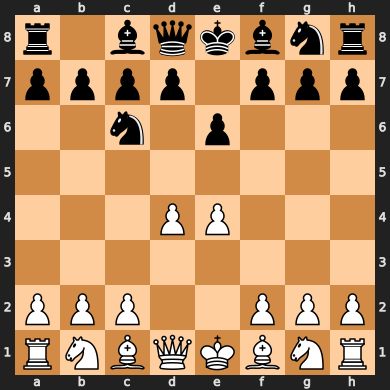





number moves: 4


In [ ]:
play()